In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cl2-assignment-8/euroSAT_train_val_test.pkl


In [2]:
#importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import pickle
import os
import pandas as pd
from torchvision import models, transforms
torch.manual_seed(22)

In [3]:
# Track currently selected GPU, and all CUDA tensors allocate will by default be created
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [4]:
#load the dataset
with open("../input/cl2-assignment-8/euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

In [5]:
# Create a custom dataset class
class CustomImageDataset(Dataset):
    #The __init__function is run once when instantiating the Dataset object.
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform
    #The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return len(self.img_labels)
    #The __getitem__function loads and returns a sample from the dataset at the given index idx
    def __getitem__(self, idx):
        image = self.img_labels[idx][0]
        label = self.img_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [6]:
#Create a train, test and Validation dataset
train_model = CustomImageDataset(train_set)
valid_model = CustomImageDataset(val_set)
test_model = CustomImageDataset(test_set)

In [7]:
# initialize the train, validation, and test data loaders
load_train = DataLoader(train_model, batch_size = 100, shuffle = True)
load_test = DataLoader(test_model, batch_size = 100, shuffle = False)
load_valid = DataLoader(valid_model, batch_size = 100, shuffle = False)

In [8]:
# Making the parameter pretrained False in Resnet 18
Resnet = models.resnet18(pretrained = False)
features = Resnet.fc.in_features
# Add an output dense layer with 10 nodes
Resnet.fc = nn.Linear(features,10)

In [9]:
# define training hyperparameters
learning_rate = 0.0001
num_epochs = 100

In [10]:
#set loss function with criterion
criterion = nn.CrossEntropyLoss()
#Optimizer Adam
optimizer = torch.optim.Adam(Resnet.parameters(), lr = learning_rate)
Resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
#Save the weights in 'logs_resnet/'
if not os.path.exists("./logs_resnet_part2"):
    os.mkdir("./logs_resnet_part2")

In [12]:
#creating the validation function to calculate the average validation loss and Validation Accuracy
def Validate_loop():
    with torch.no_grad():
        cnt, val_loss, correct, cnt_acc = 0, 0, 0, 0
        for i, (img, lab) in enumerate(load_valid):
            img = img.to(device)
            lab = lab.to(device)
            val_pred = Resnet(img)
            loss = criterion(val_pred, lab)
            correct += (val_pred.argmax(1) == lab).sum().item()
            cnt_acc += val_pred.shape[0]
            val_loss += loss.item()
            cnt = i+1
        torch.save(Resnet.state_dict(),"./logs_resnet_part2/model.pth")
        #calculate the average loss and accuracy
        avg_loss = val_loss/cnt
        per_crr = (correct/cnt_acc)*100
        #val_acc.append([avg_loss,per_crr])
        return {"avg_loss" : avg_loss, "accuracy" : per_crr}

In [13]:
#list to store the train and validation accuracy
train_acc = []
val_acc = []
valid_acc, valid_loss = 0, 0
stop = 1e+5
stp_cnt = 0
for epoch in range(num_epochs):
#Load in the data in batches using the load_train object
    train_loss, correct, cnt_acc, cnt = 0, 0, 0, 0
    for i, (images, labels) in enumerate(load_train):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        Resnet.train()
        outputs = Resnet(images)
        loss = criterion(outputs, labels)
        with torch.no_grad():
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            cnt_acc += outputs.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt = i+1
    #calculate the average loss and accuracy
    avg_loss = train_loss/cnt
    per_crr = (correct/cnt_acc)*100
    train_acc.append([avg_loss,per_crr])
    Resnet.eval()
    vld_value = Validate_loop()
    val_acc.append([vld_value["avg_loss"], vld_value["accuracy"]])
    valid_acc = vld_value["accuracy"]
    valid_loss = vld_value["avg_loss"]
    #Early stoping Condition
    if valid_loss < stop:
        torch.save(Resnet.state_dict(),"./logs_resnet_part2/model.pth")
        stop = valid_loss
        stp_cnt = 0
    stp_cnt += 1
    #print the epoch and it's accuracy and loss
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'.format(epoch+1, num_epochs, vld_value["avg_loss"], vld_value["accuracy"]))
    if(stp_cnt > 10):
        break

Epoch [1/100], Loss: 0.7750, Accuracy: 73.1125%
Epoch [2/100], Loss: 0.7758, Accuracy: 73.8604%
Epoch [3/100], Loss: 0.6409, Accuracy: 78.2407%
Epoch [4/100], Loss: 0.8845, Accuracy: 72.9701%
Epoch [5/100], Loss: 1.2427, Accuracy: 69.0527%
Epoch [6/100], Loss: 0.9103, Accuracy: 76.4957%
Epoch [7/100], Loss: 0.8679, Accuracy: 76.9943%
Epoch [8/100], Loss: 0.7795, Accuracy: 79.1667%
Epoch [9/100], Loss: 0.9016, Accuracy: 78.7749%
Epoch [10/100], Loss: 1.0264, Accuracy: 76.7450%
Epoch [11/100], Loss: 0.8160, Accuracy: 79.3091%
Epoch [12/100], Loss: 1.2994, Accuracy: 70.7621%
Epoch [13/100], Loss: 0.8266, Accuracy: 80.1638%


In [14]:
#creating the Test function to calculate the average Test loss and Test Accuracy
def test_loop():
    test_target = []
    test_predict = []
    wrong_pred = []
    with torch.no_grad():
        cnt, val_loss, correct, cnt_acc = 0, 0, 0, 0
        for i, (img, lab) in enumerate(load_test):
            test_target.extend(list(lab))
            img = img.to(device)
            lab = lab.to(device)
            val_pred = Resnet(img)
            pred_test = torch.argmax(val_pred,dim = 1).to(torch.device("cpu")).numpy()
            loss = criterion(val_pred, lab)
            correct += (val_pred.argmax(1) == lab).sum().item()
            cnt_acc += val_pred.shape[0]
            val_loss += loss.item()
            cnt = i+1
            test_predict.extend(list(pred_test))
            #checking for different predicted images
            for i in range(pred_test.shape[0]):
                if pred_test[i] != lab[i]:
                    wrong_pred.append([pred_test[i],img[i],lab[i],torch.max(val_pred)])
                #calculate the average loss and accuracy
        avg_loss = val_loss/cnt
        per_crr = (correct/cnt_acc)*100
        #print loss and accuracy
        print(f"Test loss: {avg_loss}, Accuracy: {per_crr}%")
        return {"test_target" : test_target, "test_pred" : test_predict, "wrong_pred" : wrong_pred}

In [15]:
# parameter pretrained is False
test_model = models.resnet18(pretrained = False)
features = test_model.fc.in_features
# output dense layer with 10 nodes
test_model.fc = nn.Linear(features,10)
#load the data
test_model.load_state_dict(torch.load("./logs_resnet_part2/model.pth"))
test_model.to(device)
pred_test = []
test_target = []
wrong_pred = []
# call the test function
value = test_loop()
#Store the return value
test_target = value["test_target"]
pred_test = value["test_pred"]
wrong_pred = value["wrong_pred"]

Test loss: 0.8062004673260229, Accuracy: 80.01851851851852%


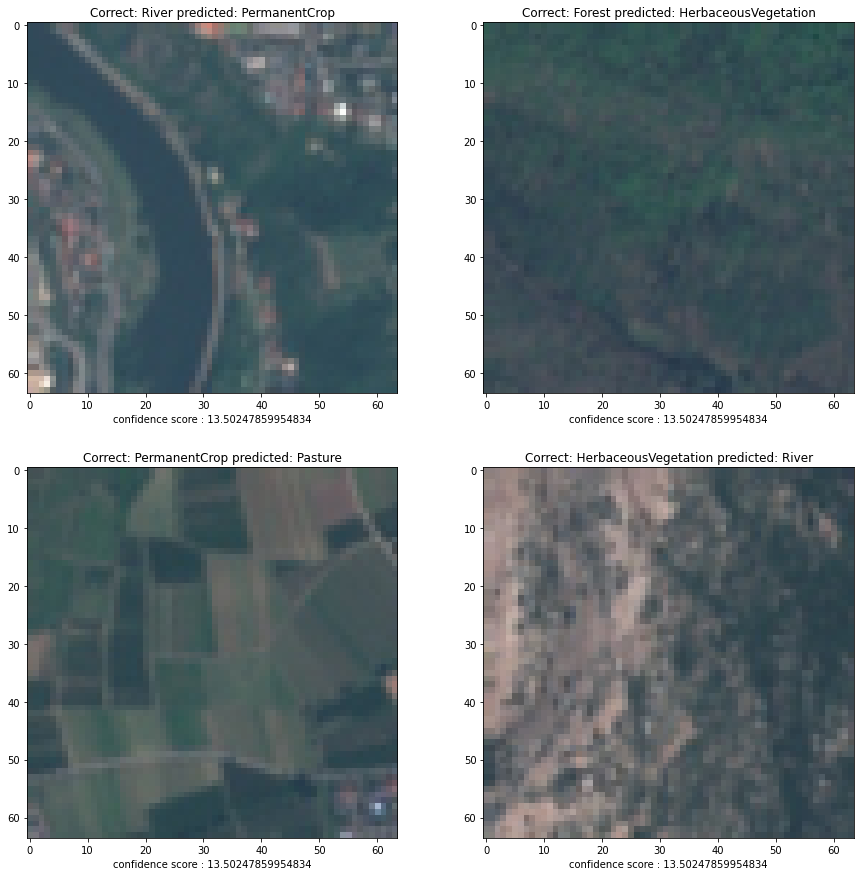

In [16]:
#import the libraries for ploting and heatmap
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# plot the Land classification wrongly predicted
labelss =['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River','SeaLake']
wrong_pred.sort(key = lambda wrong_pred: wrong_pred[3])
plt.figure(figsize = (15,15))
for idx,pred in enumerate(wrong_pred[:4]):
    img = np.array(pred[1].tolist())
    plt.subplot(2,2,idx+1)
    plt.title(f'Correct: {labelss[pred[2]]} predicted: {labelss[pred[0]]}')
    plt.xlabel(f'confidence score : {pred[3]}')
    img = np.dstack((img[0],img[1],img[2]))
    plt.imshow(img)

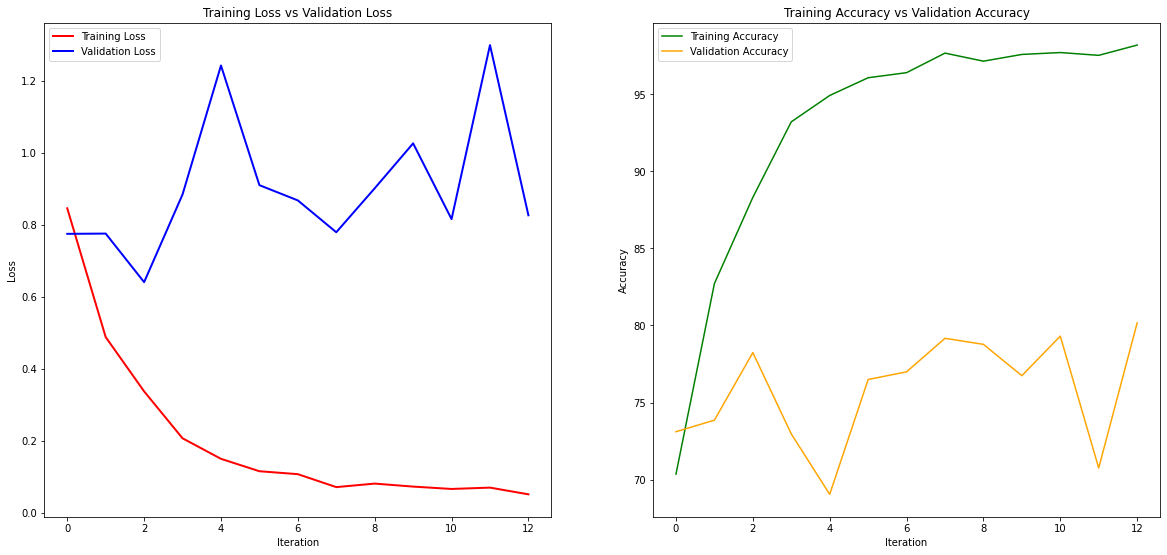

In [17]:
# ploting of loss and accuracy on the training and validation sets.
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot([i for i, _ in train_acc],linewidth = 2,color = "r",label='Training Loss')
plt.plot([i for i,_ in val_acc],linewidth = 2, color = "b",label='Validation Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.subplot(2,2,2)
plt.plot([j for _,j in train_acc],color = "green", label = 'Training Accuracy')
plt.plot([j for _,j in val_acc],color = "orange", label = 'Validation Accuracy')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.show()

In [18]:
#Importing libraries for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

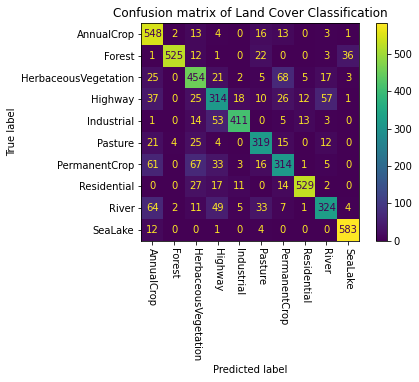

In [19]:
# Plot the confusion matrix heatmap of the test set.
classes = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]
conf_mtrx = confusion_matrix(test_target, pred_test, labels=[0,1,2,3,4,5,6,7,8,9])
ConfusionMatrixDisplay(confusion_matrix=conf_mtrx,display_labels=classes).plot()
plt.xticks(rotation=270)
plt.title('Confusion matrix of Land Cover Classification')
plt.show()